![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/legal-nlp/12.Coreference_Resolution.ipynb)

# Installation

In [ ]:
! pip install -q johnsnowlabs

## Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, legal

# nlp.install(force_browser=True)

## Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

- Install it

In [ ]:
nlp.install()

# Starting

In [ ]:
spark = nlp.start()

# Legal Correference resolution

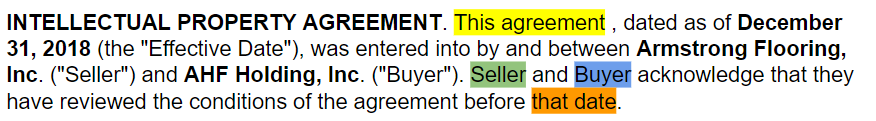

Correference Resolution is the the task of finding all expressions that refer to the same entity in a text.

This is very important in both Legal and Financial texts, where the name of the company is mentioned at the beginning of the document, but later on aliases of the company are used, intead of the official name.

Let's take a look at some examples and how to solve them using Correference Resolution.

`'Armstrong Hardwood Flooring Company is a Tennessee corporation (known also as "Company"). The Company own certain Copyrights and Know-How which may be used in the Arizona Field, and in connection with the transactions contemplated by the Stock Purchase Agreement, Arizona desires to obtain a license from the Company Entities to use such Intellectual Property on the terms and subject to the conditions set forth herein.'`

In the previous text, in the second sentence, `Company` refers to `Armstrong Hardwood Floowing Company`.

There are two ways we can accomplish correference resolution:
1. With a specific `SpanBertCorefModel` annotator;
2. With NER and Relation Extraction;

# 1. SpanBertCoref

SpanBertCorefModel annotator for Coreference Resolution on BERT and SpanBERT models based on [BERT for Coreference Resolution: Baselines and Analysis](https://arxiv.org/abs/1908.09091) paper. 

In Spark NLP, we include `SpanBertCorefModel` annotator as an implementation of this  SpanBert-based coreference resolution model.

In [ ]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence_detector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentences")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentences"])\
    .setOutputCol("tokens")

corefResolution = nlp.SpanBertCorefModel()\
    .pretrained("spanbert_base_coref")\
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("corefs")

pipeline = nlp.Pipeline(stages=[document_assembler, sentence_detector, tokenizer, corefResolution])

spanbert_base_coref download started this may take some time.
Approximate size to download 540.1 MB
[OK!]


### Who is "the Company" in this example?

In [ ]:
example1 = 'Armstrong Hardwood Flooring Company is a Tennessee corporation (known also as "Company"). The Company own certain Copyrights and Know-How which may be used to the conditions set forth herein.'

data = spark.createDataFrame([[example1]]).toDF("text")

model = pipeline.fit(data)

model.transform(data).selectExpr("explode(corefs) AS coref").selectExpr("coref.result as token", "coref.metadata").show(truncate=False)

+-----------------------------------+-----------------------------------------------------------------------------------------------------------------+
|token                              |metadata                                                                                                         |
+-----------------------------------+-----------------------------------------------------------------------------------------------------------------+
|Armstrong Hardwood Flooring Company|{head.sentence -> -1, head -> ROOT, head.begin -> -1, head.end -> -1, sentence -> 0}                             |
|The Company                        |{head.sentence -> 0, head -> Armstrong Hardwood Flooring Company, head.begin -> 0, head.end -> 34, sentence -> 1}|
+-----------------------------------+-----------------------------------------------------------------------------------------------------------------+



### What is "this Agreement" in the example? And "it"?

In [ ]:
example2 = 'This INTELLECTUAL PROPERTY AGREEMENT (this "Agreement") is dated as of December 31, 2018 (the "Effective Date").It was entered into by and between Armstrong Flooring (the "Seller") and AHF Holding (the "Buyer"). Seller and Buyer have entered into that certain Stock Purchase Agreement, dated November 14, 2018 (the "Stock Purchase Agreement")'

data = spark.createDataFrame([[example2]]).toDF("text")

model = pipeline.fit(data)

model.transform(data).selectExpr("explode(corefs) AS coref").selectExpr("coref.result as token", "coref.metadata").show(truncate=False)

+------------------+-------------------------------------------------------------------------------------------------+
|token             |metadata                                                                                         |
+------------------+-------------------------------------------------------------------------------------------------+
|this " Agreement "|{head.sentence -> -1, head -> ROOT, head.begin -> -1, head.end -> -1, sentence -> 0}             |
|It                |{head.sentence -> 0, head -> this " Agreement ", head.begin -> 38, head.end -> 53, sentence -> 1}|
+------------------+-------------------------------------------------------------------------------------------------+



### Which date are we talking about?

In [ ]:
example3 = 'This Agreement is dated as of December 31, 2018 (the "Effective Date"). Seller and Buyer should sign it before the ending of that date.'

data = spark.createDataFrame([[example3]]).toDF("text")

model = pipeline.fit(data)

model.transform(data).selectExpr("explode(corefs) AS coref").selectExpr("coref.result as token", "coref.metadata").show(truncate=False)

+------------------+-------------------------------------------------------------------------------------------------+
|token             |metadata                                                                                         |
+------------------+-------------------------------------------------------------------------------------------------+
|This Agreement    |{head.sentence -> -1, head -> ROOT, head.begin -> -1, head.end -> -1, sentence -> 0}             |
|it                |{head.sentence -> 0, head -> This Agreement, head.begin -> 0, head.end -> 13, sentence -> 1}     |
|December 31 , 2018|{head.sentence -> -1, head -> ROOT, head.begin -> -1, head.end -> -1, sentence -> 0}             |
|that date         |{head.sentence -> 0, head -> December 31 , 2018, head.begin -> 30, head.end -> 46, sentence -> 1}|
+------------------+-------------------------------------------------------------------------------------------------+



However, reality is that legal texts are often times, much longer and complex than those ones.

Let's take a look at the following example:

### Who is Seller? Who is Buyer?

FAIL: We are unable to retrieve that information using SpanBertCoref.

In [ ]:
example4 = 'This INTELLECTUAL PROPERTY AGREEMENT is entered into by and between Armstrong Flooring, Inc. ("Seller") and AHF Holding, Inc. ("Buyer"). "Seller" and "Buyer" have entered into that certain Stock Purchase Agreement, dated November 14, 2018 (the "Stock Purchase Agreement")'

data = spark.createDataFrame([[example4]]).toDF("text")

model = pipeline.fit(data)

print("\x1b[31m")
model.transform(data).selectExpr("explode(corefs) AS coref").selectExpr("coref.result as token", "coref.metadata").show(truncate=False)
print("\x1b[0m")


+--------+----------------------------------------------------------------------------------------+
|token   |metadata                                                                                |
+--------+----------------------------------------------------------------------------------------+
|Seller "|{head.sentence -> -1, head -> ROOT, head.begin -> -1, head.end -> -1, sentence -> 1}    |
|Seller "|{head.sentence -> 1, head -> Seller ", head.begin -> 95, head.end -> 101, sentence -> 3}|
+--------+----------------------------------------------------------------------------------------+




Another disadvantage of this method is that you need to send all the text at once to resolve the correferences. If you miss the original lines where the concepts are defined, you will lose the reference.

As an alternative, we can use NER and Relation Extraction, as shown in the next section.



# 2. NER and Relation Extraction

We have several models trained in Models Hub (Spark NLP for Legal), which are able to detect aliases or secondary names in financial and legal documents.

We are going to use this NER one:
`https://nlp.johnsnowlabs.com/2022/08/12/legre_contract_doc_parties_en_3_2.html`

After extracting the aliases, we will check which names they are referring to. To do this, we will use Relation Extraction. For this example, we will use this model:

`https://nlp.johnsnowlabs.com/2022/08/17/legre_org_prod_alias_en_3_2.html`

Let's see them in action.

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

tokenizer = nlp.Tokenizer()\
        .setInputCols(["document"])\
        .setOutputCol("token")

embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base","en") \
        .setInputCols(["document", "token"]) \
        .setOutputCol("embeddings")

ner_model = legal.NerModel.pretrained("legner_orgs_prods_alias", "en", "legal/models")\
        .setInputCols(["document", "token", "embeddings"])\
        .setOutputCol("ner")

ner_converter = nlp.NerConverter()\
        .setInputCols(["document","token","ner"])\
        .setOutputCol("ner_chunk")

reDL = legal.RelationExtractionDLModel()\
    .pretrained("legre_org_prod_alias", "en", "legal/models")\
    .setPredictionThreshold(0.99)\
    .setInputCols(["ner_chunk", "document"])\
    .setOutputCol("relations")

nlpPipeline = nlp.Pipeline(stages=[
        documentAssembler,
        tokenizer,
        embeddings,
        ner_model,
        ner_converter,
        reDL])

bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]
legner_orgs_prods_alias download started this may take some time.
[OK!]
legre_org_prod_alias download started this may take some time.
[OK!]


In [ ]:
example4 = 'This INTELLECTUAL PROPERTY AGREEMENT is entered into by and between Armstrong Flooring, Inc. (the "Seller") and AHF Holding, Inc., a Delaware Corporation (the "Buyer").'

data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(data)

In [ ]:
lmodel = nlp.LightPipeline(model)
res = lmodel.fullAnnotate(example4)

In [ ]:
aliases = dict()
for r in res:
  for rel in r['relations']:
    if rel.result != 'no_rel':
      aliases.setdefault(rel.metadata['chunk2'], []).append(rel.metadata['chunk1'])
      print(f"{rel.metadata['chunk1']} - {rel.result} - {rel.metadata['chunk2']} (confidence: {rel.metadata['confidence']})")

Armstrong Flooring, Inc. - has_alias - Seller (confidence: 0.9938087)
AHF Holding, Inc., a Delaware Corporation - has_alias - Buyer (confidence: 0.9923051)


In [ ]:
aliases

{'Seller': ['Armstrong Flooring, Inc.'],
 'Buyer': ['AHF Holding, Inc., a Delaware Corporation']}

Being that done, you can process the rest of the document, detecting entities as Seller, Buyer, etc with either NER or ContextualParsers, and be ablet o disambiguate it using the results of the previous model

In [ ]:
example5 = '"Seller" and "Buyer" have entered into that certain Stock Purchase Agreement, dated November 14, 2018 (the "Stock Purchase Agreement")'

nlpPipeline = nlp.Pipeline(stages=[
        documentAssembler,
        tokenizer,
        embeddings,
        ner_model,
        ner_converter])

data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(data)

In [ ]:
lmodel = nlp.LightPipeline(model)
res = lmodel.fullAnnotate(example5)

In [ ]:
for r in res:
  for ner_chunk in r['ner_chunk']:
    print(f"{ner_chunk.result} is {aliases[ner_chunk.result][0]}")

Seller is Armstrong Flooring, Inc.
Buyer is AHF Holding, Inc., a Delaware Corporation


The big advantage of using this method is that you don't need to process the whole text to know the correferences. You can detect first the aliases, store them and then resolve the correferences with NER and RE.

# 3. Question Answering

This is the third option from retrieving correferences. You can detect the alias and ask questions on the fly about what they refer to.

Let's see an example.

In [ ]:
context = 'This INTELLECTUAL PROPERTY AGREEMENT is entered into by and between Armstrong Flooring, Inc. ("Seller") and AHF Holding, Inc. ("Buyer").'.lower()
question1 = 'Which company is the Buyer'.lower()
question2 = 'Which company is the Seller'.lower()

In [ ]:
document_assembler = nlp.MultiDocumentAssembler()\
    .setInputCols(["question", "context"]) \
    .setOutputCols(["document_question", "document_context"])

spanClassifier = nlp.BertForQuestionAnswering.pretrained("legqa_bert_large","en", "legal/models")\
    .setInputCols(["document_question", "document_context"]) \
    .setOutputCol("answer") \
    .setCaseSensitive(False)

pipeline = nlp.Pipeline().setStages([
    document_assembler,
    spanClassifier
])

legqa_bert_large download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


In [ ]:
qa = [[question1, context], [question2, context]]

In [ ]:
example = spark.createDataFrame(qa).toDF("question", "context")

result = pipeline.fit(example).transform(example)

result.select('answer.result').show(truncate=False)

+----------------------------+
|result                      |
+----------------------------+
|[ahf holding , inc .]       |
|[armstrong flooring , inc .]|
+----------------------------+

